 # Home Work 2

In this hw assignment you have to train a classifier to distinguish between different food variations.

### Problem 1 (2 points)

Compute the result of convolution operation with kernel K to a matrix X.
Convolution params are: stride=2, dilation=2, padding=1 (padding with zeros)


$        X = \begin{bmatrix}
        1 & 0 & -4 & 2 \\
        5 & 2 & 3 & 0 \\
        -1 & 0 & 1 & 4 \\
        0 & -3 & 2 & -1
    \end{bmatrix}
    K = \begin{bmatrix}
        2 & 1 \\
        -1 & -2
    \end{bmatrix}
$

#### Solution:

Первым делом у нас добавляется padding, таким образом работа ведется с матрицей:

$ X = \begin{bmatrix}
        0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & -4 & 2 & 0 \\
        0 & 5 & 2 & 3 & 0 & 0 \\
        0 & -1 & 0 & 1 & 4 & 0 \\
        0 & 0 & -3 & 2 & -1 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0
    \end{bmatrix}
$
    
Так как у нас stride равен 2, значит и по строке, и по столбцам мы будем идти через две позиции, то есть в третьей строке сначала начнем с 0, зачем с 2, и так же по столбцам. Dilation значит, какое расстояние между элементами, перемножающимися с нашим фильтром: здесь dilation=2, => расстояние между элементами будет брать через одну строку/столбец, другими словами первым на фильтр поэлементно будет умножаться $ \begin{bmatrix} 0 & 0 \\ 0 & 2 \end{bmatrix} $. Получается всего четыре следующих перемножения:

$ 1) \begin{bmatrix} 0 & 0 \\ 0 & 2 \end{bmatrix} * \begin{bmatrix}
        2 & 1 \\
        -1 & -2
    \end{bmatrix} = -4
$

$
  2) \begin{bmatrix} 0 & 0 \\ 2 & 0 \end{bmatrix} * \begin{bmatrix}
        2 & 1 \\
        -1 & -2
    \end{bmatrix} = -2
$

$
  2) \begin{bmatrix} 0 & 2 \\ 0 & -3 \end{bmatrix} * \begin{bmatrix}
        2 & 1 \\
        -1 & -2
    \end{bmatrix} = 8
$

$
  2) \begin{bmatrix} 2 & 0 \\ -3 & -1 \end{bmatrix} * \begin{bmatrix}
        2 & 1 \\
        -1 & -2
    \end{bmatrix} = 9
$

Полученные значения будут находиться на соответствующих позициях итоговой матрицы.

#### Ответ: \begin{bmatrix} -4 & -2 \\ 8 & 9 \end{bmatrix}


### Problem 2 (2 points)

Count the number of trainable params in nn:

        model = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=5,
                stride=2, padding=0, dilation=1, bias=True
            ),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=5,
                stride=1, padding=1, dilation=2, bias=False
            ),
            nn.BatchNorm2d(num_features=32),
            nn.Sigmoid(),
        )
  

#### Solution:

Посчитаем количество обучаемых параметров для каждого слоя.

Для Conv2d: **(n * m * l + 1) * k**, где n и m - размеры фильтра, l - количество входных каналов, k - количество выходных каналов. Плюс 1 из-за наличия bias.

Для BatchNorm2d:  **num_features * 4**, где 4 - это четыре параметра батч_норм-а (), таким образом  This layer has 16 * 4 = 64 trainable parameters (16 features, 4 parameters per feature: weight, bias, running mean, and running variance).

Для LeakyReLU:

Для Sigmoid:

Получается, для данного задания:

1) (Conv2d) (5 * 5 * 3 + 1) * 16 = 1216 - есть баес

2) (BatchNorm2d) 16 * 2 = 32

3) (LeakyReLU) нет обучаемых параметров

4) (Conv2d) (5 * 5 * 16) * 32 = 12800 - нет баеса

5) (BatchNorm2d) 32 * 2 = 64

6) (Sigmoid) нет обучаемых параметров

Всего обучаемых параметров = 14112

### Practical problem


Solve multicalss classification problem for Food101 dataset

####  Helper code

In [ ]:
import copy
import random
import os
import shutil
import tarfile
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, Dataset

pd.set_option('display.max_colwidth', None)

In [ ]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [ ]:
url = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"

In [ ]:
dataset_directory = os.path.join(os.environ["HOME"], "datasets/food101")

In [ ]:
filepath = os.path.join(dataset_directory, "food101.tar.gz")
download_url(
    url=url,
    filepath=filepath,
)
%time extract_archive(filepath)

food101.tar.gz: 100%|██████████| 4.65G/4.65G [03:31<00:00, 23.7MB/s]


CPU times: user 44.8 s, sys: 16.2 s, total: 1min
Wall time: 1min 1s


In [ ]:
dataset_directory

'/root/datasets/food101'

### Dataloaders (1 point)


In [ ]:
NUM_WORKERS = os.cpu_count()


def split_data(dataset, seed=42):
    """
    """
    generator = torch.Generator().manual_seed(seed)
    train_data, valid_data = random_split(dataset, [0.8, 0.2], generator=generator)
    valid_data, test_data = random_split(valid_data, [0.8, 0.2], generator=generator)

    return train_data, valid_data, test_data


def create_dataloaders(
    data_dir: str,
    transform_train: transforms.Compose,
    transform_test: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder of define your Dataset class here

    dataset_train = datasets.ImageFolder(image_path, transform=transform_train)
    dataset_valid = datasets.ImageFolder(image_path, transform=transform_test)

    train_set, _ , _ = split_data(dataset_train)
    _, valid_set, test_set = split_data(dataset_valid)

    # Get class names
    meta_dir = os.path.join(data_dir, 'food-101/meta')

    with open(os.path.join(meta_dir, 'classes.txt'), 'r') as f:
        class_names = [line.strip() for line in f.readlines()]


  # Turn images into data loaders
    train_dataloader = DataLoader(
      train_set,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )

    valid_dataloader = DataLoader(
      valid_set,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )

    test_dataloader = DataLoader(
      test_set,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )

    return train_dataloader, valid_dataloader, test_dataloader, class_names

In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [ ]:
from pathlib import Path

data_path = Path(dataset_directory)
image_path = data_path / "food-101" / "images"

Define transforms. You can add augmentations for better perfomance.

 You can either use Albumentation or torchvision

Don't forget to normalize images

In [ ]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
manual_transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
batch_size = 16
num_workers = 1

In [ ]:
# dataloaders

train_dataloader, valid_dataloader, test_dataloader, class_names = create_dataloaders(data_path, manual_transforms_train, manual_transforms_test, batch_size, num_workers)

In [ ]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
len(class_names)

101

 #### Train function (2 points)




In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "epochs": 10,
}

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss = 0.0
    train_accuracy = 0.0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X = X.to(device)
        y = y.to(device)

        # 1. Forward pass
        output = model(X)

        # 2. Calculate  and accumulate loss
        loss_current = loss_fn(output, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss_current.backward()
        train_loss += loss_current.item()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        acc = (output.argmax(dim=-1) == y).float().mean()
        train_accuracy += acc.item()

    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)

    return train_loss, train_accuracy

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()
    stream = tqdm(dataloader)

    test_acc = 0
    test_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        with torch.no_grad():
            X = X.to(device)
            y = y.to(device)

            output = model(X)
            test_current_loss = loss_fn(output, y)
            test_loss += test_current_loss.item()
            output = output.detach()
            acc_test = (output.argmax(dim=-1) == y).float().cpu().mean()
            test_acc += acc_test.item()

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model = model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=valid_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)


        torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, f"{epochs}_iter.pth")

    # Return the filled results at the end of the epochs
    return results

Choose a model

In [ ]:
# возьмем модель ResNet

model = models.resnet50(pretrained=True)
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Froze several layers or tune whole model

In [ ]:
for params in model.layer1.parameters():
  params.requires_grad = False

for params in model.layer2.parameters():
  params.requires_grad = False

model.fc = nn.Linear(2048, 101)

Model summary

In [ ]:
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 101]            --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    └─

### Train (1 point)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       valid_dataloader=valid_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1263 | train_acc: 0.2519 | test_loss: 2.3044 | test_acc: 0.4179


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eafcc693760>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


  0%|          | 0/1010 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eafcc693760>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eafcc693760>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/op

Epoch: 2 | train_loss: 1.9515 | train_acc: 0.5011 | test_loss: 1.7280 | test_acc: 0.5591


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.5662 | train_acc: 0.5912 | test_loss: 1.4705 | test_acc: 0.6192


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.3507 | train_acc: 0.6421 | test_loss: 1.3297 | test_acc: 0.6555


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.1980 | train_acc: 0.6788 | test_loss: 1.3832 | test_acc: 0.6494


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 1.0797 | train_acc: 0.7079 | test_loss: 1.2272 | test_acc: 0.6890


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.9798 | train_acc: 0.7331 | test_loss: 1.2164 | test_acc: 0.6851


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.8933 | train_acc: 0.7542 | test_loss: 1.1801 | test_acc: 0.6942


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.8148 | train_acc: 0.7742 | test_loss: 1.2105 | test_acc: 0.6958


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.7405 | train_acc: 0.7933 | test_loss: 1.1329 | test_acc: 0.7079


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.6764 | train_acc: 0.8075 | test_loss: 1.0940 | test_acc: 0.7210


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.6097 | train_acc: 0.8259 | test_loss: 1.0993 | test_acc: 0.7286


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.5600 | train_acc: 0.8383 | test_loss: 1.1810 | test_acc: 0.7114


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.5038 | train_acc: 0.8539 | test_loss: 1.1286 | test_acc: 0.7314


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.4583 | train_acc: 0.8655 | test_loss: 1.1397 | test_acc: 0.7234


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.4156 | train_acc: 0.8763 | test_loss: 1.2461 | test_acc: 0.7155


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.3775 | train_acc: 0.8870 | test_loss: 1.1156 | test_acc: 0.7368


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.3430 | train_acc: 0.8960 | test_loss: 1.2098 | test_acc: 0.7304


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.3132 | train_acc: 0.9045 | test_loss: 1.3568 | test_acc: 0.7077


  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.2843 | train_acc: 0.9127 | test_loss: 1.2449 | test_acc: 0.7358
[INFO] Total training time: 11902.846 seconds


### Results (2 points in total)
Plot train and val losses

Inference model on unique subset of images


It must be very obvious that you specificaly using images that model has never seen neither during training nor evaluation steps




#### Graphs (1 point)
Plot graphs for train and val loss



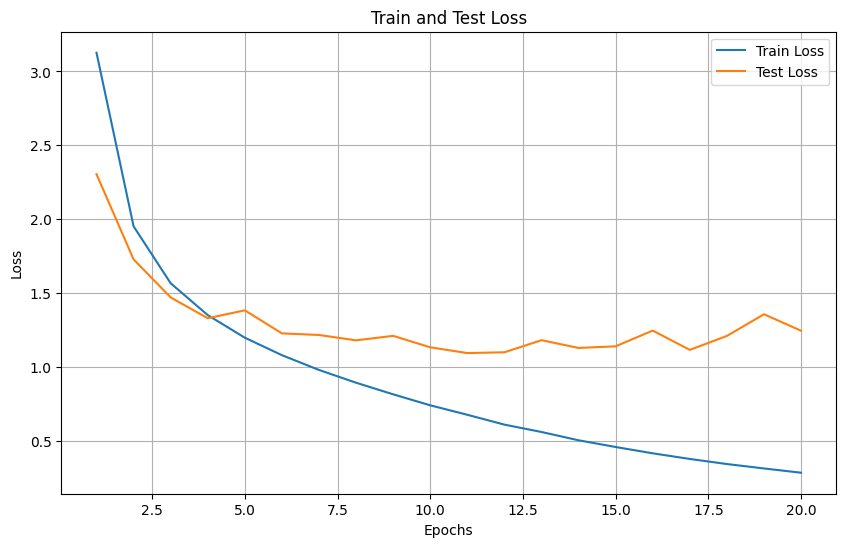

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(results['train_loss']) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, results['train_loss'], label='Train Loss')
plt.plot(epochs, results['test_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

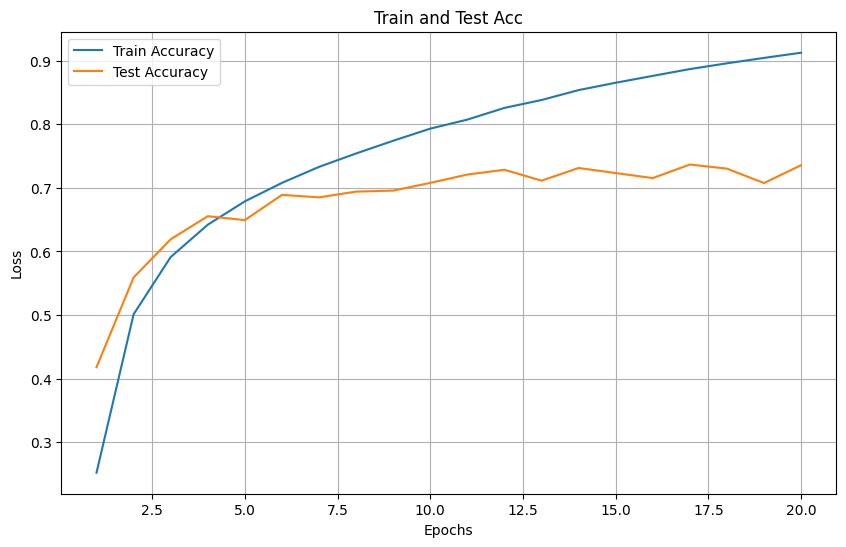

In [ ]:
epochs = range(1, len(results['train_acc']) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, results['train_acc'], label='Train Accuracy')
plt.plot(epochs, results['test_acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Acc')
plt.legend()
plt.grid(True)
plt.show()

#### Demonstration (1 point)

Show model prediction on several images

In [ ]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 73.02%


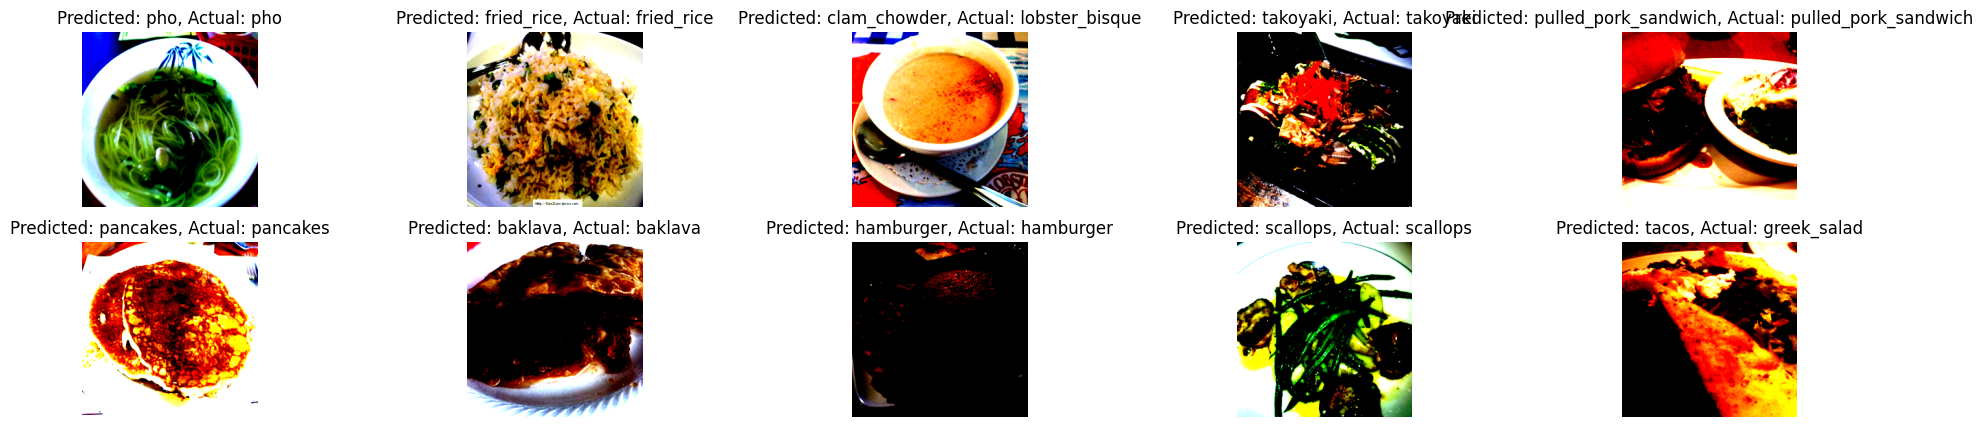

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

num_images = 10
images, labels = next(iter(test_dataloader))
images = images.to(device)
labels = labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

images = images[:num_images].permute(0, 2, 3, 1)
images = np.clip(images.cpu().numpy(), 0, 1)
norm = Normalize(vmin=0, vmax=1)

plt.figure(figsize=(24, 5))
for i in range(num_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i], norm=norm)
    plt.title(f"Predicted: {class_names[predicted[i]]}, Actual: {class_names[labels[i]]}")
    plt.axis('off')
plt.show()